In [ ]:
import os
import glob
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from PIL import Image
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Background

## Skin Cancer 
Skin cancer is one of the most common types of cancer in white populations. There are two kinds of skin cancer. The less harmful *precancerous* non‐melanoma skin cancer and the more dangerous melanoma skin cancer. In Australia, where the skin cancer rate is highest due to extreme sun exposure, the incidence rate is around 2% for non-melanoma cell carcinomas, and 0.005% for melanoma cancer (Diepgen & Mahler, 2002). These skin lesions can look similar to completely harmless non-cancerous skin lesion which is the reason why diagnostic techniques that distinguish these lesions are necessary. Nowadays, professional dermatologist have different approaches for the classification, ranging from observation to biopsy.

Skin cancer prevention initiatives are highly cost-effective (Gordon & Rowell, 2015) since the right treatment can prevent further harm effectively. There is an increasing interest regarding early detection of melanoma or skin cancer, due to the rising incidence rates. Nevertheless, the interest in decreasing mortality from this disease is always weighted against health care system costs. As Esteva et al. (2017) suggest, automated classification using artificial intelligence and convolutional neural networks (CNNs) can be promising in wide-scale screenings. Once the technology is accurate enough, people without access to a dermatologist or outside the classified high-risk groups could use their smartphones to screen themselves. Moreover, the technology could support dermatologists to increase their accuracy.

## Data Set
Tschandl et al. (2018) have provided a large data set on skin lesions. Regarding available data sets, the *HAM10000* data set is unique in its size and diversity of dermatoscopic images. It contains 10015 images of skin lesions from two population. One group of patients is from Austria and the second group is from Australia. For both places, the dermatoscopic images were taken by different devices and over a period of 20 years. The images were originally taken for educational reasons and came along with a diagnosis of the lesion which is taken as the label.

The data set consist of seven types of skin lesion and includes the above mentioned deadliest melanoma skin cancer and two other less dangerous skin cancers. Four other classes are benign skin lesions. The seven classes cover more than 95% of all lesions encountered during clinical practice. 

The number of images in the dataset differs from the number of unique lesions, because some lesions occur with different images (for example different angles). 

# Preprocessing

In [8]:
# Creation of new features necessary for the anaysis:
# Create dictionaries for the class representation's abbreviation, number and name

# These are the seven target classes
lesion_abb_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
# Assign an integer for each class
class_num_dict = {'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
# Revered dictionary
num_class_dict = {v: k for k,v in class_num_dict.items()}

# Get all image paths
# The two data foulders and the metadata file have to be in the current working directory
paths = glob.glob("ham10000_images_part_1/*") + glob.glob("ham10000_images_part_2/*")

# The file image names contain the image IDs
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in paths}

df = pd.read_csv("HAM10000_metadata.csv")
# Create three new columns with
# Path information of each lesion
df["path"] = df["image_id"].map(image_path_dict.get)
# Full name of the target
df["cell_type"] = df["dx"].map(lesion_abb_dict.get)
# Numerical code of the target
df["target"] = df["dx"].map(class_num_dict.get)

In [11]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,target
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ham10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ham10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ham10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ham10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ham10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2


### Class Distribution
Below, one can see the occurence of the seven skin lesion types. As one can see, the dataset is unbalanced in its target classes. The belign class 0 (Melanocytic nevi) has a frequency of around 67%, the smallest class 6 (Dermatofibroma) has a prevalence of only around 1%. The malignant Melanomas occur with over 10% which is an overrepresentation compared to their real prevalence in humans.

In [3]:
df["cell_type"].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

## Example
For a better intuitive understanding, an example of an image of a skin lesion is shown below. The image size is 450 x 600 for all images.

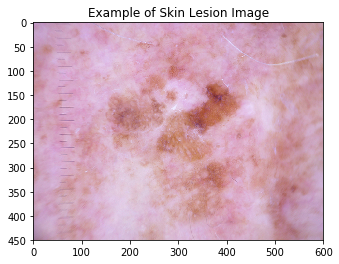

In [12]:
plt.imshow(np.array(Image.open("ham10000_images_part_1/ISIC_0027419.jpg")))
plt.title("Example of Skin Lesion Image");


## Create Train, Validation and Test Sets
As usual, for training puposes and to evaluate the classification, the data set is split into one large train set and two smaller validation and test sets.
### Level of Split
Normally, the data is split into train, test and validation set at the image level. In our case, some skin lesions occur in the dataset with multiple images. The usage of a validation and test set is to hold back data from the model to check if it is able to generalize. Two different images of the same skin lesion can be too similar and thus should not be spread across train, validation and test set. Therefore, the data is split on the skin lesion level, as given by lesion_ID.

### Stratified Sampling
As one can see in the class distribution table, the target classes in this data set are unbalanced. The most dominant group makes up 67% of the data while the rarest target occurs in 1% of the cases. For numbers as small as here, if one would split without any further constrains as described above, the validation and test set could risk to have too few samples of the rare groups. Therefore, a stratified splitting method is used which splits proportional to the target class. Nevertheless, due to the nature of this data set, while mitigating this effect, there are only few examples of Dermatofibroma in the validation and test sets.

In [5]:
# Get a new dataframe based on a unique list of lesion IDs
df_without_duplicates = df.drop_duplicates(subset="lesion_id")
ids = df_without_duplicates.lesion_id.tolist()
targets = df_without_duplicates.target.tolist()
# Split the data into train (70%) and validation (30%) set
# Stratify on the level of the targets
train_ids, val_ids, train_targets, val_targets = train_test_split(
    ids, targets, test_size=0.30, random_state=123, stratify=targets)

# Use the validation data (30%) and split it further into validation (15%) and test (15%) set
# Again with a stratification on the target
val_ids, test_ids, val_targets, test_targets = train_test_split(
    val_ids, val_targets, test_size=0.50, random_state=123, stratify=val_targets)

# Creating a new column in the dataframe called "set"
# where the set membership is noted
df["set"] = "train"
df.loc[df["lesion_id"].isin(val_ids), "set"] = "val"
df.loc[df["lesion_id"].isin(test_ids), "set"] = "test"

**Output Below**: Target Distribution in Train, Validation and Test Set.
As one can see, the smallest number of occurence is 14 for the Dermatofibroma target in the test set.

In [6]:
df.groupby("cell_type")["set"].value_counts()

cell_type                       set  
Actinic keratoses               train     229
                                test       50
                                val        48
Basal cell carcinoma            train     370
                                val        75
                                test       69
Benign keratosis-like lesions   train     758
                                val       173
                                test      168
Dermatofibroma                  train      82
                                val        19
                                test       14
Melanocytic nevi                train    4695
                                test     1014
                                val       996
Melanoma                        train     774
                                test      177
                                val       162
Vascular lesions                train     102
                                val        24
                                test      

## Resizing
The image data is coded in 400 x 600 x 3 dimensional arrays representing the intensity of red, blue and green for each point of the image. To save computational time and RAM, here, the image is resized to one sixth of its original size. When resizing the image data, a trade-off between computational time and higher accuracy has to be made. The higher the resolution, the more information can be used and thus the accuracy tends to be higher. On the other hand a higher resolution will increase the data volume and thus lowering the speed of the classification. 

In [7]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

In [8]:
# Conditional on the set membership arrays of the pixel data arrays are created 
x_train = np.asarray(df.loc[df["lesion_id"].isin(train_ids), 'image'].tolist())
x_val = np.asarray(df.loc[df["lesion_id"].isin(val_ids), 'image'].tolist())
x_test = np.asarray(df.loc[df["lesion_id"].isin(test_ids), 'image'].tolist())


## Normalization
For the normalization, the image data points are set between zero and one. In the RGB model the colour ranges from zero to 255. Therefore a division by the maximum value will normalize the image data.

In [9]:
# Changing the type to float number
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)
x_test = x_test.astype(np.float32)
# Division by their maximum value
x_train /= 255.
x_val /= 255.
x_test /= 255.

In [10]:
# The train data consists of 7010 images, each with 75x100 points with each 3 dimensions
x_train.shape

(7010, 75, 100, 3)

## One-Hot Vector Encoding
The target variable will be one-hot vector encoded. This means that the target variable will be a vector of length seven with exactly six zeros and one one at the position of the target's class. [0,0,0,1,0,0,0] for example represents a target of class number "3".

In [11]:
# The target variable will be one-hot-encoded
y_train = to_categorical(df.loc[df["lesion_id"].isin(train_ids), 'target'])
y_val = to_categorical(df.loc[df["lesion_id"].isin(val_ids), 'target'])
y_test = to_categorical(df.loc[df["lesion_id"].isin(test_ids), 'target'])

# Classification
## Transfer Learning
Transfer learning has become an increasingly popular method for image classification tasks. The main idea is to leverage the knowledge learned by models from other datasets. The two main advantages are the prevention of overfitting due to the generalized features and the saving in computational time, since previous weights can be used which minimizes the amount of estimated parameters drastically. 

Cutting off the last layers of the networks, the remaining first layers produce features that are general enough to function as features on even different image sets. More precisely, first-layer features consist mostly of Gabor filters (texture) or color blobs (Yosinski et al., 2014). The domain specific classification occurs in the last layer where the features are connected to the target space of the task.

As Shin et al. (2016) show, this method can also be used with models trained on ImageNet data for medical image classification.

### Imagenet
ImageNet (Russakovky et al., 2015) is a large and widely-used dataset that contains over 14 million images and over 20,000 categories. The models and weights used here, were trained on this dataset. As written above, it was shown that this transfer can be effective.
### CNN Architectures
Keras offers several implemented CNN models for image classification that were trained on ImageNet. These models can be either used with pre-trained weights or without them. The difference is that without the weights, only the network architecture is implemented but completely trained on the current data set. When the weights are "frozen" and transfered to the current analysis, the process is called "transfer learning" and is described above.

Overall, six different models are implemented. Three different architectures, once with and once without pre-trained weights, to compare their performances and check whether the ImageNet-features are transferable to the Skin data set or not. The three architectures are introduced in the following.
#### ResNet50
ResNet50 is the smallest of all ResNet models. The name is an abbreviation for "Residual Network". The name follows from the fact, that this family of networks uses "residual learning". By creating short-cut connections to layers that are not directly neighboring, this architecture can generate residuals that describe a difference between features. Residual networks are easier to optimize and can thus effectively handle largely increased depth (He et al., 2016). ResNet architectures are therefore multiple times deeper than for example the VGG net architectures.

#### Xception
Xception is an extension of the *Inception* architecture which replaces the standard Inception modules with depthwise separable convolutions (Chollet, 2016). Inception models have a composition of processing units at each state and concatenate the outputs afterwards. This way, they form parallel paths in their deep neural networks which lowers the computational costs to allow for increased depth and width of the network (Szegedy, 2014).

#### InceptionResNetV2	
The InceptionResNetV2 combines the two approaches of residual learning and *Inception* architectures. Szegedy (2016) show that this combination can outperform similarly expensive *Inception* models without residual connections.

## Model Configurations
When using the trained CNN models as the stem model, some settings can be configured. Here, we want to transfer learn and not classify images that have an equivalent class in the ImageNet dataset. To adjust the base model to our classification problem, the last fully-connected layer at the top of the network is excluded from the model and will be replaced by a dense layer of length seven.

Through Global Average Pooling the output tensor of the stem model will be reduced from a 4D tensor output to a 2D tensor output. Compared to a plain flattening layer, this leads to a drastic reduction of parameters that have to be estimated and thus saving computational resources and time. Moreover Global Average Pooling has been proven to be a good prevention against overfitting, due to the strong reduction in parameters.

Using Global Average Pooling means that in the end there is no locational information of a feature but rather its overall prevalence in an image. This makes sure that features are weighted irregardless of their position in the image.

## Model 1
The architecture of the *ResNet50* model for Model 1 can be seen below. The output are a 2048 features gained by Average Global Pooling. Each feature is then fully connected to the seven targets. This leads to 14,336 weights. Seven further bias terms increase this number of parameters to 14,343 parameters, as one can see in the last row of the model1.summary()-output. If the parameters are taken from previous analysis (Model 1), only 14,343 parameters have to be trained. Otherwise, it is more than 20 mio parameters (Model 2).
The configurations are described and commented in detail for Model 1. The other five models are equivalent in their configuration and thus not commented and describes in detail again.

In [12]:
# The stem model is the ResNet50
# In model 1 the pre-trained weights are used
model1 = ResNet50(weights='imagenet', input_shape=(75, 100, 3), include_top=False, pooling="avg")
print(model1.summary())

Instructions for updating:
Colocations handled automatically by placer.
94658560/94653016 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 106, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 38, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 38, 50, 64)   256         conv1[

In [13]:
model1.output

<tf.Tensor 'global_average_pooling2d_1/Mean:0' shape=(?, 2048) dtype=float32>

In [14]:
model1_output = model1.output
#final layer with softmax activation
output1 = Dense(len(class_num_dict.keys()), activation='softmax')(model1_output)
# Now the stem model is combined with the last layer
# The input is the same as before, but for the output
# an additional Dense layer was added
model1 = Model(inputs=model1.input, outputs=output1)

In [15]:
model1.output

<tf.Tensor 'dense_1/Softmax:0' shape=(?, 7) dtype=float32>

In [16]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 106, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 38, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 38, 50, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [17]:
# As an optimizer the Adam optimizer is used with a starting learning rate of 0.001
# Since one-hot-ecoded vectors are used the categorical cross entropy is used as the loss and the metric
# is set to the top-1 accuracy
model1.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

## Data Augmentation
Additional artificial image data is generated by transforming the original training pictures by rotating, zooming, shifting and flipping. This way the properties of natural images are considered: The same skin lesion can be photographed under different light settings thus changing the color and contrast. Similarly, another angle can lead to distorted images. This form of data augmentation is introduced by Krizhevsky, A. et al. (2012) to prevent overfitting.

In [18]:
datagen = ImageDataGenerator(
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True, 
        vertical_flip=True)  

# A datagenerator without augmentation is used for the validation set
datagen_no_da = ImageDataGenerator()

## Running the Model
### Number of Episodes
The number of episodes is not determined before the model is run but rather adapts to the progress of the estimation.
The "early_stopping" function monitors the validation accuracy and stops the iteration when the change becomes small enough. More precisely, the "patience" variable is the number of epoches where the validation accuracy does not improve until the run is stoped. To work with the weights of the model with the highest validation accuracy the function "checkpoint" ensures that the weight of this episode are saved. Later episodes with lower validation accuracy will be ignored.
### Learning Rate Reduction
To reduce the learning rate whenever the improvements in the accuracy have decreased, an adaptive learning rate is implemented. This way minima of the loss function can be found more effectively. When the improvment regarding the validation accuracy is large, it is more effective to have higher learning rates. When the improvement becomes small, it helps to decrease the learning rate to be able to find minima of the loss function. It is important here to set the "patients" variable higher for the stopping function than for the learning rate reduction function: For some threshold of accuracy improvement the learning rate is reduced. Another, significantly smaller, threshold activates the stopping function.

In [19]:
# The early stopping and checkpoint mechanisms as described above
early_stopping = EarlyStopping(monitor="val_acc", patience=5, verbose=1)
# The weight of the run with the best results are saved as "best_weights1"
checkpoint = ModelCheckpoint("best_weights1.h5", monitor="val_acc", save_best_only=True)

# The adaptive learning rate as described above
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# For each episode the input data is shuffled to create a different order for the inputs
# The steps per epoch equal the overall data divided through the batch site of 32:
# This way, in every episode, the model iterates over all images.

# The callbacks incorporate the three above described functions to determinde stopping and learning rate
model1.fit_generator(datagen.flow(x_train, y_train, batch_size=32, shuffle=True), steps_per_epoch=len(x_train)//32+1, 
                    epochs=100, verbose=1, callbacks=[learning_rate_reduction, checkpoint, early_stopping], 
                    validation_data=datagen_no_da.flow(x_val, y_val, batch_size=32, shuffle=False), 
                    validation_steps=len(x_val)//32+1, workers=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
220/220 [==============================] - 34s 153ms/step - loss: 0.8760 - acc: 0.7098 - val_loss: 1.0130 - val_acc: 0.6921
Epoch 2/100
220/220 [==============================] - 21s 96ms/step - loss: 1.0330 - acc: 0.7071 - val_loss: 5.0458 - val_acc: 0.6653
Epoch 3/100
220/220 [==============================] - 21s 95ms/step - loss: 0.8556 - acc: 0.7067 - val_loss: 0.8791 - val_acc: 0.6987
Epoch 4/100
220/220 [==============================] - 21s 97ms/step - loss: 0.7754 - acc: 0.7197 - val_loss: 0.8923 - val_acc: 0.7021
Epoch 5/100
220/220 [==============================] - 21s 96ms/step - loss: 0.8015 - acc: 0.7240 - val_loss: 2.8705 - val_acc: 0.6894
Epoch 6/100
220/220 [==============================] - 21s 94ms/step - loss: 0.7464 - acc: 0.7405 - val_loss: 0.7168 - val_acc: 0.7435
Epoch 7/100
220/220 [==============================] - 21s 96ms/step - loss: 0.8767 - acc: 0.7152 - val_loss: 0.7831 - val_acc: 0.7335
Epoch 

In [20]:
# Basic Model Evaluation
model1.load_weights("best_weights1.h5")
loss, accuracy = model1.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model1.evaluate(x_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

1497/1497 [==============================] - 1s 688us/step
Validation: accuracy = 0.784903  ;  loss_v = 0.618498
Test: accuracy = 0.763926  ;  loss = 0.607728


## Model 2
The only difference between Model 1 and Model 2 is usage of the pre-trained weights for model 1 and the complete training without pre-trained weights for model 2.

In [22]:
model2 = ResNet50(weights=None, input_shape=(75, 100, 3), include_top=False, pooling="avg")
model2_output = model2.output
output2 = Dense(len(class_num_dict.keys()), activation='softmax')(model2_output) #final layer with softmax activation
model2 = Model(inputs=model2.input, outputs=output2)

model2.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint("best_weights2.h5", monitor="val_acc", save_best_only=True)

model2.fit_generator(datagen.flow(x_train, y_train, batch_size=32, shuffle=True), steps_per_epoch=len(x_train)//32+1, 
                    epochs=100, verbose=1, callbacks=[learning_rate_reduction, checkpoint, early_stopping], 
                    validation_data=datagen_no_da.flow(x_val, y_val, batch_size=32, shuffle=False), 
                    validation_steps=len(x_val)//32+1, workers=1)

Epoch 1/100
220/220 [==============================] - 40s 181ms/step - loss: 1.1549 - acc: 0.6477 - val_loss: 1.3287 - val_acc: 0.4983
Epoch 2/100
220/220 [==============================] - 22s 99ms/step - loss: 0.9028 - acc: 0.6811 - val_loss: 1.3111 - val_acc: 0.6794
Epoch 3/100
220/220 [==============================] - 23s 102ms/step - loss: 0.7972 - acc: 0.7133 - val_loss: 1.1151 - val_acc: 0.6754
Epoch 4/100
220/220 [==============================] - 21s 96ms/step - loss: 0.7537 - acc: 0.7240 - val_loss: 0.8675 - val_acc: 0.7007
Epoch 5/100
220/220 [==============================] - 22s 99ms/step - loss: 0.7546 - acc: 0.7179 - val_loss: 1.0139 - val_acc: 0.6219
Epoch 6/100
220/220 [==============================] - 21s 97ms/step - loss: 0.7738 - acc: 0.7264 - val_loss: 0.8229 - val_acc: 0.6854

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
220/220 [==============================] - 22s 98ms/step - loss: 0.7286 - acc: 0.7359 - val_los

In [23]:
model2.load_weights("best_weights2.h5")
loss, accuracy = model2.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model2.evaluate(x_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

1497/1497 [==============================] - 1s 713us/step
Validation: accuracy = 0.764863  ;  loss_v = 0.679818
Test: accuracy = 0.757958  ;  loss = 0.672892


## Model 3
Model three uses the *Xception* architecture and its ImageNet pre-trained weights.

In [24]:
model3 = Xception(weights="imagenet", input_shape=(75, 100, 3), include_top=False, pooling="avg")
model3_output = model3.output
output3 = Dense(len(class_num_dict.keys()), activation='softmax')(model3_output) #final layer with softmax activation
model3 = Model(inputs=model3.input, outputs=output3)

model3.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint("best_weights3.h5", monitor="val_acc", save_best_only=True)

model3.fit_generator(datagen.flow(x_train, y_train, batch_size=32, shuffle=True), steps_per_epoch=len(x_train)//32+1, 
                    epochs=100, verbose=1, callbacks=[learning_rate_reduction, checkpoint, early_stopping], 
                    validation_data=datagen_no_da.flow(x_val, y_val, batch_size=32, shuffle=False), 
                    validation_steps=len(x_val)//32+1, workers=1)

model3.load_weights("best_weights3.h5")
loss, accuracy = model3.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model3.evaluate(x_val, y_val, verbose=1)
print("Model 3: Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Model 3: Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

83689472/83683744 [==============================] - 3s 0us/step
Epoch 1/100
220/220 [==============================] - 38s 172ms/step - loss: 0.7956 - acc: 0.7207 - val_loss: 0.9451 - val_acc: 0.7041
Epoch 2/100
220/220 [==============================] - 22s 99ms/step - loss: 0.6538 - acc: 0.7644 - val_loss: 0.7936 - val_acc: 0.7802
Epoch 3/100
220/220 [==============================] - 22s 100ms/step - loss: 0.6369 - acc: 0.7828 - val_loss: 0.6868 - val_acc: 0.7769
Epoch 4/100
220/220 [==============================] - 22s 98ms/step - loss: 0.5707 - acc: 0.7948 - val_loss: 0.6136 - val_acc: 0.7482

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/100
220/220 [==============================] - 22s 100ms/step - loss: 0.4669 - acc: 0.8247 - val_loss: 0.5990 - val_acc: 0.7929
Epoch 6/100
220/220 [==============================] - 22s 101ms/step - loss: 0.4088 - acc: 0.8503 - val_loss: 0.6799 - val_acc: 0.7862
Epoch 7/100
220/220 [===================

# Model 4
Model 4 uses the *Xception* architecture but without any pre-trained weights.

In [25]:
model4 = Xception(weights=None, input_shape=(75, 100, 3), include_top=False, pooling="avg")
model4_output = model4.output
output4 = Dense(len(class_num_dict.keys()), activation='softmax')(model4_output) #final layer with softmax activation
model4 = Model(inputs=model4.input, outputs=output4)

model4.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint("best_weights4.h5", monitor="val_acc", save_best_only=True)

model4.fit_generator(datagen.flow(x_train, y_train, batch_size=32, shuffle=True), steps_per_epoch=len(x_train)//32+1, 
                    epochs=1000, verbose=1, callbacks=[learning_rate_reduction, checkpoint, early_stopping], 
                    validation_data=datagen_no_da.flow(x_val, y_val, batch_size=32, shuffle=False), 
                    validation_steps=len(x_val)//32+1, workers=1)

model4.load_weights("best_weights4.h5")
loss, accuracy = model4.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model4.evaluate(x_val, y_val, verbose=1)
print("Model 4: Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Model 4: Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Epoch 1/1000
220/220 [==============================] - 41s 185ms/step - loss: 0.9400 - acc: 0.6639 - val_loss: 1.1204 - val_acc: 0.6593
Epoch 2/1000
220/220 [==============================] - 22s 101ms/step - loss: 0.8155 - acc: 0.6999 - val_loss: 3.3682 - val_acc: 0.1804
Epoch 3/1000
220/220 [==============================] - 22s 100ms/step - loss: 0.7633 - acc: 0.7187 - val_loss: 0.9338 - val_acc: 0.6473

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/1000
220/220 [==============================] - 22s 100ms/step - loss: 0.6781 - acc: 0.7467 - val_loss: 0.7033 - val_acc: 0.7528
Epoch 5/1000
220/220 [==============================] - 23s 103ms/step - loss: 0.6686 - acc: 0.7521 - val_loss: 0.7616 - val_acc: 0.7381
Epoch 6/1000
220/220 [==============================] - 22s 101ms/step - loss: 0.6824 - acc: 0.7529 - val_loss: 0.6739 - val_acc: 0.7522

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 7/1000
220

# Model 5
Model 5 uses the *InceptionResNetV2* architecture and on ImageNet pre-trained weights. 

In [26]:
model5 = InceptionResNetV2(weights='imagenet', input_shape=(75, 100, 3), include_top=False, pooling="avg")
model5_output = model5.output
output5 = Dense(len(class_num_dict.keys()), activation='softmax')(model5_output) #final layer with softmax activation
model5 = Model(inputs=model5.input, outputs=output5)

model5.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint("best_weights5.h5", monitor="val_acc", save_best_only=True)

model5.fit_generator(datagen.flow(x_train, y_train, batch_size=32, shuffle=True), steps_per_epoch=len(x_train)//32+1, 
                    epochs=100, verbose=1, callbacks=[learning_rate_reduction, checkpoint, early_stopping], 
                    validation_data=datagen_no_da.flow(x_val, y_val, batch_size=32, shuffle=False), 
                    validation_steps=len(x_val)//32+1, workers=1)

model5.load_weights("best_weights5.h5")
loss, accuracy = model5.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model5.evaluate(x_val, y_val, verbose=1)
print("Model 5: Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Model 5: Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

219062272/219055592 [==============================] - 7s 0us/step
Epoch 1/100
220/220 [==============================] - 119s 539ms/step - loss: 0.9146 - acc: 0.7186 - val_loss: 3.2281 - val_acc: 0.6700
Epoch 2/100
220/220 [==============================] - 57s 261ms/step - loss: 0.7423 - acc: 0.7530 - val_loss: 0.7773 - val_acc: 0.7522
Epoch 3/100
220/220 [==============================] - 58s 262ms/step - loss: 0.6186 - acc: 0.7785 - val_loss: 1.1526 - val_acc: 0.6894
Epoch 4/100
220/220 [==============================] - 57s 260ms/step - loss: 0.7020 - acc: 0.7801 - val_loss: 0.6558 - val_acc: 0.7782
Epoch 5/100
220/220 [==============================] - 58s 262ms/step - loss: 0.7495 - acc: 0.7780 - val_loss: 0.7527 - val_acc: 0.7348
Epoch 6/100
220/220 [==============================] - 58s 263ms/step - loss: 0.7195 - acc: 0.7804 - val_loss: 1.7686 - val_acc: 0.6820

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
220/220 [==============

# Model 6

Model 6 uses the *InceptionResNetV2* architecture but without any pre-trained weights. 

In [27]:
model6 = InceptionResNetV2(weights=None, input_shape=(75, 100, 3), include_top=False, pooling="avg")
model6_output = model6.output
output6 = Dense(len(class_num_dict.keys()), activation='softmax')(model6_output) #final layer with softmax activation
model6 = Model(inputs=model6.input, outputs=output6)

model6.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint("best_weights6.h5", monitor="val_acc", save_best_only=True)

model6.fit_generator(datagen.flow(x_train, y_train, batch_size=32, shuffle=True), steps_per_epoch=len(x_train)//32+1, 
                    epochs=100, verbose=1, callbacks=[learning_rate_reduction, checkpoint, early_stopping], 
                    validation_data=datagen_no_da.flow(x_val, y_val, batch_size=32, shuffle=False), 
                    validation_steps=len(x_val)//32+1, workers=1)

model6.load_weights("best_weights6.h5")
loss, accuracy = model6.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model6.evaluate(x_val, y_val, verbose=1)
print("Model 6: Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Model 6: Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Epoch 1/100
220/220 [==============================] - 146s 662ms/step - loss: 0.9694 - acc: 0.6800 - val_loss: 1.0953 - val_acc: 0.6232
Epoch 2/100
220/220 [==============================] - 59s 268ms/step - loss: 0.8226 - acc: 0.7033 - val_loss: 1.1734 - val_acc: 0.6573
Epoch 3/100
220/220 [==============================] - 59s 270ms/step - loss: 0.8227 - acc: 0.7067 - val_loss: 5.3942 - val_acc: 0.6653
Epoch 4/100
220/220 [==============================] - 59s 266ms/step - loss: 0.9622 - acc: 0.6769 - val_loss: 1.5841 - val_acc: 0.6927
Epoch 5/100
220/220 [==============================] - 59s 266ms/step - loss: 0.9244 - acc: 0.6801 - val_loss: 0.9049 - val_acc: 0.6273
Epoch 6/100
220/220 [==============================] - 58s 265ms/step - loss: 0.8985 - acc: 0.6888 - val_loss: 0.8938 - val_acc: 0.6847

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
220/220 [==============================] - 58s 264ms/step - loss: 0.7873 - acc: 0.7172 - v

# Model Selection
As one can see in the table below, the models with pre-trained weights outperform those without pre-trained weights.
The model attributes of parameters and ImageNet Validation Top1-Accuracy of the networks are taken from the [keras documentation](http://https://keras.io/applications/).
## Results of the Model Comparisons


| Model Number | Model Name        | Pre-Trained Weights | Parameters | ImageNet Validation Top1-Accuracy | Number of Epoches | SKIN Test Top1-Accuracy |
|--------------|-------------------|---------------------|------------|-----------------------------------|-------------------|-------------------------|
| 1            | ResNet50          | Yes                 | 25,636,712 | 0.749                             | 32                | 0.764                   |
| 2            | ResNet50          | No                  | 25,636,712 | 0.749                             | 19                | 0.758                   |
| 3            | Xception          | Yes                 | 22,910,480 | 0.790                             | 23                | 0.805                   |
| 4            | Xception          | No                  | 22,910,480 | 0.790                             | 30                | 0.777                   |
| 5            | InceptionResNetV2 | Yes                 | 55,873,736 | 0.803                             | 22                | 0.796                   |
| 6            | InceptionResNetV2 | No                  | 55,873,736 | 0.803                             | 34                 | 0.774                   |

## Evaluation
Model 3 and Model 5 achieve test top-1 accuracies of around 80%. For further more detailed evaluations, these two models will be analysed.
### Overview Multiclass Classification
As visible below, in both models, except for one case, the lesions are classified most often as their true label. The only exception is in Model 5 melanomas that wrongly get classified as benign most frequently.

In [29]:
# Function to plot confusion matrix    
# Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = 0.8
    else:
        thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



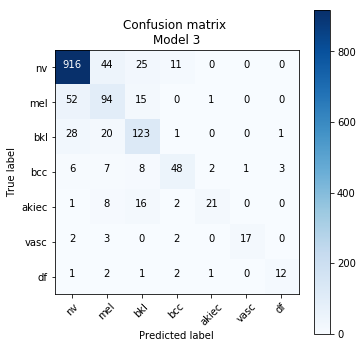

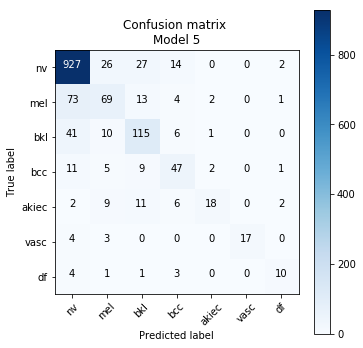

In [34]:
models=[model3,model5]
for i in range(2):
    # Predict the values from the validation dataset
    Y_pred = models[i].predict(x_val)
    # Convert predictions classes to one hot vectors
    Y_pred_classes = np.argmax(Y_pred, axis = 1)
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(y_val, axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plot_confusion_matrix(confusion_mtx, classes=class_num_dict.keys(), normalize=False, title="Confusion matrix \nModel %d"%(((i+1)*2)+1)) 

## Case specific evaluation
In the medical diagnostic case, different misclassifications result in different consequences. Mistaking benign classes with each other is less harmfull than wrongly classifying dangerous cancer as benign. Moreover the loss is not considered symmetric. The cost of not detecting cancer is considered much higher than falsely diagnosing one. A false positive result is less harmful than a false negative one. 

To evaluate the image classification more accurately, two new metrics are designed. Class 1, 3 and 4 are cancerous where class 1 (melanom) is especially dangerous. One metric will calculate the performance in distinguishing all forms of cancer from the rest and the second metric will evaluate the distinction between melanoms from the other groups.

In [56]:
def cancer_detection(model, threshold=0.5):
    '''This function returns the confusion matrix for
    binary cancer detection for a given model and threshold'''
    
    # Define target 1,3 and 4 as dangerous carcinomial lesions
    # and the other four groups as benign
    y_true=[1 if np.argmax(y_test[i]) in [1,3,4] else 0 for i in range(len(y_test))]
    # Predict the values from the validation dataset
    y_pred = model.predict(x_test)
    y_pred=[1 if y_pred[i][1]+y_pred[i][3]+y_pred[i][4] > threshold else 0 for i in range(len(y_test))]
    confusion_mtrx=confusion_matrix(y_true,y_pred)
    return(confusion_mtrx)  

def melanom_detection(model, threshold=0.5):
    '''This function returns the confusion matrix for
    binary melanom detection for a given model and threshold'''
    # Define target 1 as melonom carcinomial lesions
    # and the other six groups as not-melonom lesions
    y_true=[1 if np.argmax(y_test[i]) in [1] else 0 for i in range(len(y_test))]
    # Predict the values from the validation dataset
    y_pred = model.predict(x_test)
    y_pred=[1 if y_pred[i][1] > threshold else 0 for i in range(len(y_test))]
    confusion_mtrx=confusion_matrix(y_true,y_pred)
    return(confusion_mtrx)    
  

### Cancer Detection

In [57]:
model3_cd = cancer_detection(model3)
print(model3_cd)
model5_cd = cancer_detection(model5)
print(model5_cd)

[[1117   95]
 [ 119  177]]
[[1142   70]
 [ 140  156]]


In [58]:
acc3cd=(model3_cd[0,0]+model3_cd[1,1])/(sum(sum(model3_cd)))
fn3cd=model3_cd[1,0]/sum(model3_cd)[1]
fp3cd=model3_cd[0,1]/sum(model3_cd)[0]
print("For model 3 the cancer binary-accuracy is", acc3cd, "\nThe false positive rate is", fp3cd,"and the false negative rate is",
     fn3cd)
acc5cd=(model5_cd[0,0]+model5_cd[1,1])/(sum(sum(model5_cd)))
fn5cd=model5_cd[1,0]/sum(model5_cd)[1]
fp5cd=model5_cd[0,1]/sum(model5_cd)[0]
print("For model 5 the cancer binary-accuracy is", acc5cd, "\nThe false positive rate is", fp5cd,"and the false negative rate is",
     fn5cd)

For model 3 the cancer binary-accuracy is 0.8580901856763926 
The false positive rate is 0.07686084142394822 and the false negative rate is 0.4375
For model 5 the cancer binary-accuracy is 0.8607427055702918 
The false positive rate is 0.054602184087363496 and the false negative rate is 0.6194690265486725


### Melanom Detection

In [59]:
model3_cd = melanom_detection(model3)
print(model3_cd)
model5_cd = melanom_detection(model5)
print(model5_cd)
acc3cd=(model3_cd[0,0]+model3_cd[1,1])/(sum(sum(model3_cd)))
fn3cd=model3_cd[1,0]/sum(model3_cd)[1]
fp3cd=model3_cd[0,1]/sum(model3_cd)[0]
print("For model 3 the melanoma binary-accuracy is", acc3cd, "\nThe false positive rate is", fp3cd,"and the false negative rate is",
     fn3cd)
acc5cd=(model5_cd[0,0]+model5_cd[1,1])/(sum(sum(model5_cd)))
fn5cd=model5_cd[1,0]/sum(model5_cd)[1]
fp5cd=model5_cd[0,1]/sum(model5_cd)[0]
print("For model 5 the melanoma binary-accuracy is", acc5cd, "\nThe false positive rate is", fp5cd,"and the false negative rate is",
     fn5cd)

[[1248   83]
 [  82   95]]
[[1280   51]
 [ 110   67]]
For model 3 the melanoma binary-accuracy is 0.8905835543766578 
The false positive rate is 0.062406015037593986 and the false negative rate is 0.4606741573033708
For model 5 the melanoma binary-accuracy is 0.8932360742705571 
The false positive rate is 0.03669064748201439 and the false negative rate is 0.9322033898305084


## Adaptive Threshold 
These results are not satisfactory. With values between 0.4 to 0.9 cancer is not detected as such. To solve this, one can reduce the threshold of the probability for cancer for its classification. A threshold of 0.2 can mean to consider a lesion to be cancer even if the classification assigns a probability of only 0.2 to this.

As one can see, a higher treshold value leads to more false negative cases and vice versa. 

In [65]:
thresholds=np.arange(0, 1, 0.05)
resultsFN=[]
resultsFP=[]
costs=[]
for t in thresholds:
    results=cancer_detection(model3, t)
    resultsFN.append(results[1,0])
    resultsFP.append(results[0,1])


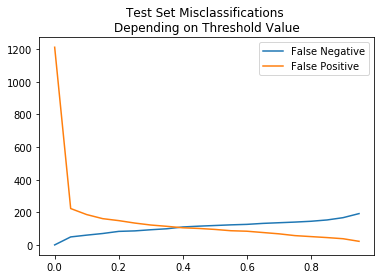

In [66]:
plt.plot(thresholds,resultsFN, label="False Negative")
plt.plot(thresholds,resultsFP, label="False Positive")
plt.legend()
plt.title("Test Set Misclassifications \nDepending on Threshold Value");

To understand the relationship between this threshold and the costs of misclassification, a graph for Model 3 is plotted below. With the help of the "cost" function, a threshold can be chosen that optimizes subjective costs of false classifications.

As an example, the cost for a false negative result is set to be ten times as high as a false positive classification. Here, the optimal threshold would be around 5%. This would mean to classify lesions as potential cancer whenever the CNN assigns a probability higher than 5% to cancer.

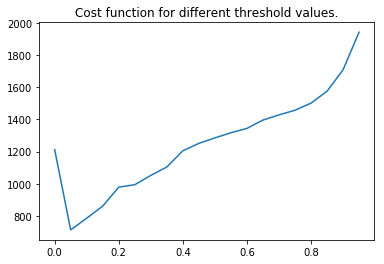

In [71]:
def costs(fn, fp, costFP=1, costFN=10):
    '''Calculates the "cost" of misclassification errors'''
    cost=[fn[i]*costFN+costFP*fp[i] for i in range(len(fn))]
    return(cost)

costs=costs(resultsFN,resultsFP)
plt.plot(thresholds,costs, label="Costs") 
plt.title("Cost function for different threshold values.");

# Conclusion

## Results
The most dominant category has a prevalence of around 70%. This means that a model that always predicts this category would have an accuracy of already 70%. The described models add up to a further ten percentage points to that.

The achieved maximum test top1-accuracy of 0.805 for model 3 is as high or higher than the value of the two [highest ranked kaggle result for this data set with values of 0.808](https://www.kaggle.com/vbookshelf/skin-lesion-analyzer-tensorflow-js-web-app) and [0.77](https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy). This suggests, and confirms previous studies such as Shin et a.(2016), that the approach of transfer learning was successful and can be superior in achieving higher accuracy rates in medical image data.

The results of this analysis are promising for automated image classification. Although the pre-trained models were trained on non-medical data, their features are useful for this task. As shown in the evaluation, the threshold for identification can be adjusted to different levels of risk-aversion. 

## Further Improvement
One of the most challenging aspects of this analysis, is the unbalanced prevalence of the target classes. This aspect can, for example, be further tackled by adding augmented versions of the rare classes to the data set to artificially increase their class.

Regarding the asymetric loss function of missclassification, a specific loss function could be designed and integrated that weights different misclassifications with their real cost.

Furthermore, if the computational power is available, the image size can be increased and even deeper networks with more parameters can be used.

## Potential Use-Cases
Depending on the application of such an skin lesion classifier, different pre-trained models can be used. The decision which one to use is a trade-off between speed, computational resources and accuracy. A potential application could use this kind of image classifier to build an app where people can use their smartphone to analyse skin lesions.

Dermatological examinations come with a cost for the health care system. The incorporation of Deep Learning Methods to either support dermatologists in their decision making or to replace them whenever not available has the potential to save lives. Even small changes in the number of wrong diagnosis can have a huge impact given the large number of effected people.

# References
Chollet, F. (2017). Xception: Deep learning with depthwise separable convolutions. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1251-1258).

Diepgen, T.L. and Mahler, V., 2002. The epidemiology of skin cancer. British Journal of Dermatology, 146, pp.1-6.

Gordon, L.G. and Rowell, D., 2015. Health system costs of skin cancer and cost-effectiveness of skin cancer prevention and screening: a systematic review. European Journal of Cancer Prevention, 24(2), pp.141-149.

He, K., Zhang, X., Ren, S. and Sun, J., 2016. Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

Krizhevsky, A., Sutskever, I., & Hinton, G. E. , 2012. Imagenet classification with deep convolutional neural networks. In Advances in neural information processing systems (pp. 1097-1105).

Russakovsky, O., Deng, J., Su, H., Krause, J., Satheesh, S., Ma, S., Huang, Z., Karpathy, A., Khosla, A., Bernstein, M. and Berg, A.C., 2015. Imagenet large scale visual recognition challenge. International journal of computer vision, 115(3), pp.211-252.

Shin, H.C., Roth, H.R., Gao, M., Lu, L., Xu, Z., Nogues, I., Yao, J., Mollura, D. and Summers, R.M., 2016. Deep convolutional neural networks for computer-aided detection: CNN architectures, dataset characteristics and transfer learning. IEEE transactions on medical imaging, 35(5), pp.1285-1298.

Szegedy, C., Liu, W., Jia, Y., Sermanet, P., Reed, S., Anguelov, D., ... & Rabinovich, A., 2015. Going deeper with convolutions. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1-9).

Szegedy, C., Ioffe, S., Vanhoucke, V., & Alemi, A. A., 2017. Inception-v4, inception-resnet and the impact of residual connections on learning. In Thirty-First AAAI Conference on Artificial Intelligence.

Tschandl, P., Rosendahl, C. and Kittler, H., 2018. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Scientific data, 5, p.180161.

Yosinski, J., Clune, J., Bengio, Y. and Lipson, H., 2014. How transferable are features in deep neural networks?. In Advances in neural information processing systems (pp. 3320-3328).